#### Library

In [1]:
import matplotlib.pyplot as plt
import gdown
from PIL import Image
import PIL
import torch
import torch.nn as nn
from torchsummary import summary
import torchvision
import torchvision.transforms as T
import torchvision.utils as vutils
import random
import torch.backends.cudnn as cudnn

In [2]:
# seed 고정
def random_seed(seed_num):
    torch.manual_seed(seed_num)
    torch.cuda.manual_seed(seed_num)
    torch.cuda.manual_seed_all(seed_num)
    cudnn.benchmark = False
    cudnn.deterministic = True
    random.seed(seed_num)

random_seed(42)

#### VGG Model

In [3]:
model = torch.hub.load('pytorch/vision', 'vgg19', weights='VGG19_Weights.DEFAULT')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

model.eval()

Using cache found in /Users/mungughyeon/.cache/torch/hub/pytorch_vision_main


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [4]:
# VGG19에 랜덤한 input tensor를 넣은 뒤 각 레이어를 거친 후의 output shape이 어떻게 달라지는지 확인
x = torch.randn(1, 3, 224, 224).to(device)

model_stats = summary(model, x, verbose=0)
model_summary = str(model_stats)
print(model_summary)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        1,792
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        36,928
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       73,856
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       147,584
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         295,168
|    └─ReLU: 2-12                        [-1, 256, 56, 56]      

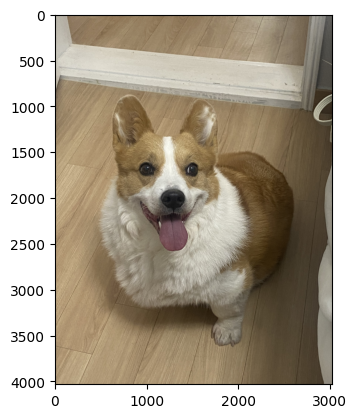

In [5]:
# 예시 이미지로 확인
# !gdown '1GmbdIn0lDZOOU0ym86GULUHGmhPZWEKz' --output dog.jpg
im = Image.open("../data/dog.jpg").rotate(270, PIL.Image.NEAREST, expand = 1)
plt.imshow(im)

In [6]:
# 불러온 이미지를 model의 input으로 쓸 수 있도록 transform하는 과정
preprocess = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),              # 이미지의 가장 짧은 변을 256 픽셀로 리사이즈 (비율 유지)
    torchvision.transforms.CenterCrop(224),          # 중앙 기준으로 224x224 영역을 잘라냄
    torchvision.transforms.ToTensor(),               # PIL 이미지를 [0, 1] 범위의 텐서 (C x H x W) 로 변환
    torchvision.transforms.Normalize(                # 텐서를 정규화: 평균과 표준편차 기준으로 값 분포 조정
        mean=[0.485, 0.456, 0.406],                   # (R, G, B) 채널별 평균
        std=[0.229, 0.224, 0.225]                     # (R, G, B) 채널별 표준편차
    )
])
im_tensor = preprocess(im)
im_tensor = im_tensor.unsqueeze(0).to(device) # 이미지를 batch 형태로 바꾸어 줌 (B x C x W x H)
print(im.size, im_tensor.shape)

(3024, 4032) torch.Size([1, 3, 224, 224])


In [7]:
# gradient 계산 안함: 학습이 아닌 추론을 위해
with torch.no_grad():
    output = model(im_tensor)
    print(output)

# 출력 텐서의 차원 확인
print(output.shape)

# softmax 함수를 사용하여 확률 값으로 변환
prob = torch.nn.functional.softmax(output[0], dim=0)
print(prob)

# softmax를 취하면 확률값이 되므로 전체 합은 1
print(f'\n** Sum of the output tensors \nBefore the softmax: {sum(output[0]).item():.4f} -> After the softmax: {sum(prob).item():.4f}')

tensor([[-2.5623e+00, -2.6427e+00, -2.7711e+00, -5.1314e+00, -2.3244e+00,
         -2.9408e+00, -3.7921e+00, -9.6670e-01,  2.4775e-01, -4.5901e+00,
         -2.6993e+00, -7.0859e-01, -5.3228e+00, -3.5907e+00, -5.7952e+00,
         -2.3933e+00, -1.6593e+00, -1.9006e+00, -6.9913e-01, -2.1542e+00,
         -4.9090e-01, -2.8056e+00, -1.5130e+00, -1.9163e+00, -2.8678e+00,
         -2.4582e+00, -6.3031e+00, -3.9912e+00, -3.3807e+00, -6.0341e+00,
         -3.4487e+00, -2.8675e+00, -4.9649e+00, -3.6082e+00, -3.5954e+00,
         -5.1230e+00, -2.3048e+00, -1.9920e+00, -3.9610e+00, -3.8025e+00,
         -2.4950e+00, -4.7556e+00, -5.1879e+00, -4.5868e+00, -3.8172e+00,
         -2.9911e+00, -1.7572e+00, -4.2569e+00, -4.5330e+00, -3.8421e+00,
         -2.8932e+00, -2.6516e+00, -2.8833e+00, -2.3837e+00, -3.3906e+00,
         -1.2401e+00, -1.1550e-01, -3.5806e+00, -2.5864e+00, -2.5273e+00,
         -3.4670e-01, -1.4616e+00, -2.0438e+00, -3.8651e+00, -1.2031e+00,
         -2.7492e+00, -2.5415e+00,  2.

In [9]:
# label import
with open("../data/imagenet_classes.txt", "r") as f:
    classes = [s.strip() for s in f.readlines()]  # readlines: 텍스트 파일을 줄 단위로 읽어 리스트로 반환

# top 5 출력
top5_prob, top5_classes = torch.topk(prob, 5) # torch.topk: Tensor의 상위 값과 index 반환
for i in range(top5_prob.size(0)):
    print(f"Class: {classes[top5_classes[i]]} | Score: {top5_prob[i].item():.4f}")

Class: Pembroke | Score: 0.9138
Class: Cardigan | Score: 0.0851
Class: Chihuahua | Score: 0.0002
Class: papillon | Score: 0.0001
Class: Pomeranian | Score: 0.0001
